In [2]:
%pylab inline
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import random

Populating the interactive namespace from numpy and matplotlib
/Users/yinze/miniforge3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
resolution = 592.747
round_resolution = round(resolution)
image_path = 'crater_dataset/images/'
label_path = 'crater_dataset/labels/'
image_names = os.listdir(image_path)

25_-174.png
30_-2.png
-13_138.png


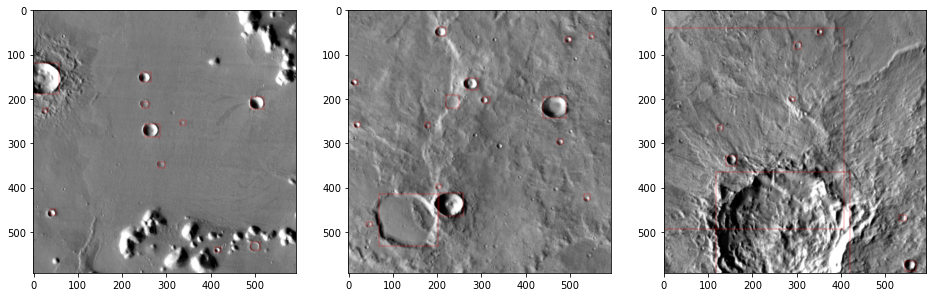

In [5]:
random.shuffle(image_names)
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

for i in range(3):
    image_name = image_names[i]
    im = Image.open(image_path + image_name)
    ax[i].imshow(im, cmap='gray')
    size, size = im.size
    label_name = image_name[:-3] + 'txt'
    print(image_name)
    f = open(label_path + label_name, 'r')
    for line in f.readlines():
        c, x, y, w, h = line.split(' ')
        x = float(x) * size
        y = float(y) * size
        w = float(w) * size
        h = float(h) * size
        x -= w / 2
        y -= h / 2
        rect = patches.Rectangle((x, y), w, h, linewidth=0.3, edgecolor='r', facecolor='none')
        ax[i].add_patch(rect)
    f.close()